In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download playground-series-s3e24
! mkdir /content/data
! unzip playground-series-s3e24.zip -d /content/data

 73% 5.00M/6.81M [00:00<00:00, 45.0MB/s]
100% 6.81M/6.81M [00:00<00:00, 53.2MB/s]
Archive:  playground-series-s3e24.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
train_dataset  = '/content/data/train.csv'
train = pd.read_csv(train_dataset)

In [ ]:
print("Назви колонок:")
print(train.columns)

print("\nРозмір датасета:")
print(train.shape)

train = train.dropna()
train = train.drop('id', axis=1)

print(train.nunique())
columns_to_normalize = [ 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp']


scaler = MinMaxScaler()
train[columns_to_normalize] = scaler.fit_transform(train[columns_to_normalize])

target_column = 'hearing(left)'
train[target_column].replace({1: 0, 2: 1}, inplace=True)

target_column = 'hearing(right)'
train[target_column].replace({1: 0, 2: 1}, inplace=True)

print("Нормалізований DataFrame:")
print(train.head())

Назви колонок:
Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

Розмір датасета:
(159256, 24)
age                     18
height(cm)              14
weight(kg)              28
waist(cm)              531
eyesight(left)          20
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               112
relaxation              75
fasting blood sugar    229
Cholesterol            227
triglyceride           392
HDL                    108
LDL                    222
hemoglobin             134
Urine protein            6
serum creatinine        28
AST                    140
ALT                    188
Gtp                    362
dental ca

In [ ]:
y = train['smoking']
X = train.drop('smoking', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Повнозв'язані нейронні мережі

In [ ]:
counts = (y_train == 1).sum()
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts, 100 * float(counts) / len(y_train)
    )
)

weight_for_0 = 1.0 / (len(y_train) - counts)
weight_for_1 = 1.0 / counts

Number of positive samples in training data: 55584 (43.63% of total)


In [ ]:

model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5888      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 137729 (538.00 KB)
Trainable params: 13772

In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.keras")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
)

Epoch 1/30
63/63 - 7s - loss: 1.0468e-05 - fn: 12520.0000 - fp: 36333.0000 - tn: 35487.0000 - tp: 43064.0000 - precision: 0.5424 - recall: 0.7748 - val_loss: 0.6109 - val_fn: 3033.0000 - val_fp: 6526.0000 - val_tn: 11257.0000 - val_tp: 11036.0000 - val_precision: 0.6284 - val_recall: 0.7844 - 7s/epoch - 115ms/step
Epoch 2/30
63/63 - 4s - loss: 8.7002e-06 - fn: 10859.0000 - fp: 25179.0000 - tn: 46641.0000 - tp: 44725.0000 - precision: 0.6398 - recall: 0.8046 - val_loss: 0.5208 - val_fn: 1904.0000 - val_fp: 6535.0000 - val_tn: 11248.0000 - val_tp: 12165.0000 - val_precision: 0.6505 - val_recall: 0.8647 - 4s/epoch - 60ms/step
Epoch 3/30
63/63 - 3s - loss: 7.9394e-06 - fn: 7292.0000 - fp: 26082.0000 - tn: 45738.0000 - tp: 48292.0000 - precision: 0.6493 - recall: 0.8688 - val_loss: 0.4971 - val_fn: 1591.0000 - val_fp: 6574.0000 - val_tn: 11209.0000 - val_tp: 12478.0000 - val_precision: 0.6549 - val_recall: 0.8869 - 3s/epoch - 48ms/step
Epoch 4/30
63/63 - 3s - loss: 7.7081e-06 - fn: 6847.000

In [ ]:
y_pred_train = model.predict(X_train)

3982/3982 [==============================] - 11s 3ms/step


In [ ]:
y_pred_valid = model.predict(X_valid)

996/996 [==============================] - 3s 3ms/step


In [ ]:
def round_2(val,threshold):
  if val > threshold:
    return 1
  return 0

In [ ]:
for i in range(1,10):
  y_pred_valid0 = [round_2(value,float(i)/10)  for value in y_pred_valid.reshape(len(y_pred_valid))]
  print("Валідаційні дані:")
  print(classification_report(y_valid, y_pred_valid0))
  print(confusion_matrix(y_valid, y_pred_valid0))

Валідаційні дані:
              precision    recall  f1-score   support

           0       0.98      0.40      0.57     17783
           1       0.57      0.99      0.72     14069

    accuracy                           0.66     31852
   macro avg       0.77      0.70      0.65     31852
weighted avg       0.80      0.66      0.64     31852

[[ 7202 10581]
 [  174 13895]]
Валідаційні дані:
              precision    recall  f1-score   support

           0       0.96      0.49      0.65     17783
           1       0.60      0.98      0.74     14069

    accuracy                           0.70     31852
   macro avg       0.78      0.73      0.70     31852
weighted avg       0.80      0.70      0.69     31852

[[ 8694  9089]
 [  333 13736]]
Валідаційні дані:
              precision    recall  f1-score   support

           0       0.95      0.54      0.69     17783
           1       0.62      0.96      0.76     14069

    accuracy                           0.73     31852
   macro avg

In [ ]:
y_pred_valid0 = [round_2(value,0.6)  for value in y_pred_valid.reshape(len(y_pred_valid))]
y_pred_train0 = [round_2(value,0.6)  for value in y_pred_train.reshape(len(y_pred_train))]
print("Валідаційні дані:")
print(classification_report(y_valid, y_pred_valid0))
print(confusion_matrix(y_valid, y_pred_valid0))
print("Тренувальні дані:")
print(classification_report(y_train, y_pred_train0))
print(confusion_matrix(y_train, y_pred_train0))

Валідаційні дані:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     17783
           1       0.72      0.76      0.74     14069

    accuracy                           0.77     31852
   macro avg       0.76      0.76      0.76     31852
weighted avg       0.77      0.77      0.77     31852

[[13714  4069]
 [ 3412 10657]]
Тренувальні дані:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     71820
           1       0.72      0.76      0.74     55584

    accuracy                           0.77    127404
   macro avg       0.77      0.77      0.77    127404
weighted avg       0.77      0.77      0.77    127404

[[55579 16241]
 [13123 42461]]


Порівняно з одержаними раніше результатами: різниці немає.

# Згорткові нейронні мережі

In [ ]:
! mkdir /content/data
! kaggle datasets download sujaykapadnis/smoking
! unzip smoking.zip -d /content/data

mkdir: cannot create directory ‘/content/data’: File exists
 88% 56.0M/63.8M [00:00<00:00, 145MB/s]
100% 63.8M/63.8M [00:00<00:00, 145MB/s]
Archive:  smoking.zip
  inflating: /content/data/Testing/Testing/notsmoking_0004.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0014.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0018.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0026.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0032.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0036.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0041.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0049.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0053.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0058.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0062.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0069.jpg  
  inflating: /content/data/Testing/Testing/notsmoking_0075

In [ ]:
from tensorflow import data as tf_data
import os
import shutil
from google.colab import drive
from keras import layers,models
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image


In [ ]:



source_folder_path_2 = '/content/data/Validation/Validation'
source_folder_path_3 = '/content/data/Testing/Testing'
source_folder_path = '/content/data/Training/Training'
smoking_folder_path = '/content/data/Training/Training/smoking'
not_smoking_folder_path = '/content/data/Training/Training/notsmoking'

os.makedirs(smoking_folder_path, exist_ok=True)
os.makedirs(not_smoking_folder_path, exist_ok=True)

all_files = os.listdir(source_folder_path)
af2 = os.listdir(source_folder_path_2)
af3 = os.listdir(source_folder_path_3)


for file_name in all_files:
  if file_name=='notsmoking' or file_name=='smoking':
    continue
  source_file_path = os.path.join(source_folder_path+'/', file_name)


  if file_name.lower().startswith('smoking'):
      destination_file_path = os.path.join(smoking_folder_path+'/', file_name)
      shutil.move(source_file_path, destination_file_path)
  else:
      destination_file_path = os.path.join(not_smoking_folder_path+'/', file_name)
      shutil.move(source_file_path, destination_file_path)
for file_name in af2:
  if file_name=='notsmoking' or file_name=='smoking':
    continue
  source_file_path_2 = os.path.join(source_folder_path_2+'/', file_name)


  if file_name.lower().startswith('smoking'):
      destination_file_path = os.path.join(smoking_folder_path+'/', file_name)
      shutil.move(source_file_path_2, destination_file_path)
  else:
      destination_file_path = os.path.join(not_smoking_folder_path+'/', file_name)
      shutil.move(source_file_path_2, destination_file_path)

print("Images moved successfully.")

Images moved successfully.


In [ ]:
img_height, img_width, channels = 256, 256, 3
image_size = (256, 256)
dataset_path = '/content/data/Training/Training'
batch_size = 16

train_data, test_data = keras.utils.image_dataset_from_directory(
    "/content/data/Training/Training",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 896 files belonging to 2 classes.
Using 717 files for training.
Using 179 files for validation.


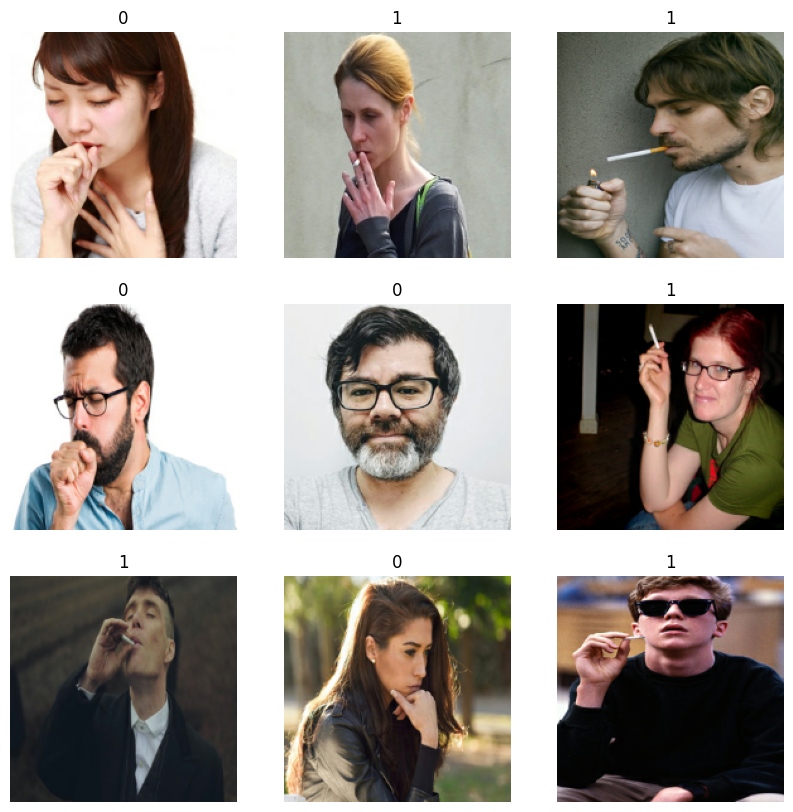

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow_from_directory(
    "/content/data/Training/Training",
    target_size=(180, 180),
    batch_size=16,
    class_mode='binary'
)

Found 896 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [ ]:


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    train_data,
    epochs=20,
    callbacks=[early_stopping],
    validation_data = test_data
)

Epoch 1/20
45/45 [==============================] - 107s 2s/step - loss: 69.9762 - accuracy: 0.5788 - val_loss: 0.6739 - val_accuracy: 0.6425
Epoch 2/20
45/45 [==============================] - 103s 2s/step - loss: 0.6161 - accuracy: 0.6848 - val_loss: 0.6765 - val_accuracy: 0.6425
Epoch 3/20
45/45 [==============================] - 104s 2s/step - loss: 0.4885 - accuracy: 0.7643 - val_loss: 0.8027 - val_accuracy: 0.6704
Epoch 4/20
45/45 [==============================] - 110s 2s/step - loss: 0.3228 - accuracy: 0.8536 - val_loss: 1.0163 - val_accuracy: 0.5698
Epoch 5/20
45/45 [==============================] - 106s 2s/step - loss: 0.1952 - accuracy: 0.9317 - val_loss: 1.6329 - val_accuracy: 0.5922
Epoch 6/20
45/45 [==============================] - 114s 2s/step - loss: 0.1500 - accuracy: 0.9414 - val_loss: 1.7698 - val_accuracy: 0.6089
Epoch 7/20
45/45 [==============================] - 103s 2s/step - loss: 0.0976 - accuracy: 0.9623 - val_loss: 1.8942 - val_accuracy: 0.6592
Epoch 8/20
4

1/1 [==============================] - 0s 182ms/step
This image is 65.58% not smoking and 34.42% smoking.


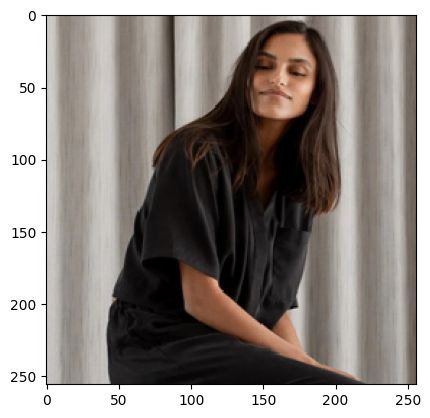

In [ ]:

image_path = '/content/data/Testing/Testing/notsmoking_0014.jpg'
img = image.load_img(image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0
plt.imshow(img)
predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% not smoking and {100 * score:.2f}% smoking.")

# Рекурентні нейронні мережі

In [ ]:
import string
import re
from sklearn.preprocessing import LabelEncoder

In [ ]:
! kaggle datasets download subhajournal/phishingemails
! unzip phishingemails.zip -d /content/data

 28% 5.00M/18.0M [00:00<00:00, 41.8MB/s]
100% 18.0M/18.0M [00:00<00:00, 102MB/s] 
Archive:  phishingemails.zip
  inflating: /content/data/Phishing_Email.csv  


In [ ]:
train_text_dataset  = '/content/data/Phishing_Email.csv'
train_3 = pd.read_csv(train_text_dataset)

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))
def clean_text(text):
  text = re.sub("https*\S+", " ", text)
  text = re.sub("@\S+", " ", text)
  text = re.sub("#\S+", " ", text)
  text = re.sub("\d", " ", text)
  text = re.sub('\n', " ", text)
  return text

In [ ]:
train_3 = train_3.drop('Unnamed: 0',axis=1)
train_3 = train_3.dropna()
train_3  = train_3.drop_duplicates(subset=['Email Text'])
train_3['Email Text'] = train_3['Email Text'].apply(remove_punctuation)
train_3['Email Text'] = train_3['Email Text'].str.lower()
train_3['Email Text'] = train_3['Email Text'].apply(clean_text)

In [ ]:
y = train_3['Email Type']
X = train_3['Email Text']
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
max_words = 1000
max_len = 100

In [ ]:
VOCAB_SIZE = 20000
encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train_3)

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_3['Email Text'])
sequences = tokenizer.texts_to_sequences(train_3['Email Text'])
X = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_3['Email Type'])

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train_3, y_train_3, epochs=5, batch_size=32, validation_split=0.2)



Epoch 1/5
351/351 [==============================] - 14s 36ms/step - loss: 0.4022 - accuracy: 0.8077 - val_loss: 0.1805 - val_accuracy: 0.9344
Epoch 2/5
351/351 [==============================] - 14s 40ms/step - loss: 0.1679 - accuracy: 0.9394 - val_loss: 0.1618 - val_accuracy: 0.9394
Epoch 3/5
351/351 [==============================] - 12s 35ms/step - loss: 0.1183 - accuracy: 0.9595 - val_loss: 0.1471 - val_accuracy: 0.9440
Epoch 4/5
351/351 [==============================] - 9s 25ms/step - loss: 0.1047 - accuracy: 0.9635 - val_loss: 0.1519 - val_accuracy: 0.9462
Epoch 5/5
351/351 [==============================] - 12s 35ms/step - loss: 0.0814 - accuracy: 0.9742 - val_loss: 0.1749 - val_accuracy: 0.9383


In [ ]:
loss, accuracy = model.evaluate(X_test_3, y_test_3)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

110/110 [==============================] - 1s 11ms/step - loss: 0.1715 - accuracy: 0.9441
Test Loss: 0.1715, Test Accuracy: 0.9441


Порівняно з результатами у лабі №2 RNN трохи гірша